In [1]:
%reload_ext autoreload
%autoreload 2

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Functions-stash" data-toc-modified-id="Functions-stash-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Functions stash</a></span></li></ul></li><li><span><a href="#Generalized-Convex-Hull-construction-(Light-IO)" data-toc-modified-id="Generalized-Convex-Hull-construction-(Light-IO)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generalized Convex Hull construction (Light IO)</a></span></li><li><span><a href="#TODO:-append-IZA(+)-to-DEEM-330k" data-toc-modified-id="TODO:-append-IZA(+)-to-DEEM-330k-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TODO: append IZA(+) to DEEM 330k</a></span></li></ul></div>

In [2]:
# General purpose
import os, sys
import time
from glob import glob
import copy
import h5py

# Maths
import numpy as np
import random
from scipy.spatial.distance import pdist,squareform
from scipy.linalg import eigh as EIGH
from scipy.spatial import ConvexHull as chull
from scipy.interpolate import griddata as sing
from scipy.special import erfcinv, erfinv

# ML
from sklearn.linear_model import Ridge as ridgereg
from sklearn.decomposition import PCA
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
from soap import librascal_soap

# Atoms
from ase.io import read, write

# Plotting
import matplotlib.pyplot as plt

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Functions stash

In [3]:
class Hullpoints:
    def __init__(self, index, contour,name):
        self.idx = index  ### Indices of hullpoints on the smap
        self.cntr = contour   ### Distances from the convex hull
        self.nm   = name       # Name of the selection
 
# TODO: get rid of this
def pca(X,n=12,y=[0.0]):
    """ Computes the first n Principal components """
    pc = PCA(n_components=n)
    pc.fit(X)
    if len(y) == 1:
        pp = pc.transform(X)
    else:
        pp = pc.transform(y)
    return pp,pc.explained_variance_ratio_
    
# TODO: replace this with library function
def do_fps(x, d=0):
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = np.random.randint(0, n)
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
    return iy
    
def get_refgch(pfile, inrg=0, cols=[]):
    """
    [[pfile]] : matrix : energy + kpca 
    ndim               : number of dimensions of the low dimensional hull we use as reference
    inrg               : index of energy column
    [cols ] : list     : list of indices of columns of pfile to be used for the LD hull construction
    """
    
    data = pfile[:,cols]
    ndim = len(cols)
    nresdim = len(pfile[0,ndim::])
    hull = chull(data)
    
 
    HD_kpca = pfile[:,ndim::]
    snormals = hull.equations[:,0:ndim]
    sshifts  = hull.equations[:,ndim]

    vlist = hull.vertices
    if inrg >= 0 :  # discards points that face down in the given direction
        slist = hull.simplices
        vlist = np.asarray([], int)

        for i in range(len(slist)):
            if snormals[i,inrg] < 0.:
                vlist = np.union1d(vlist, slist[i])

    ns = len(sshifts)
    nd = len(data)
    ss = np.zeros((nd),dtype='int')

    projs = np.zeros((nd,ndim-1),dtype='float')
    interp_HDkpca = np.zeros((nd,pfile.shape[1]-ndim),dtype='float')

    elist = np.ones((len(data),2))*1e100
    sigma_s = np.zeros((nd,nresdim),dtype='float') ### Structural variance in the higher dimensions
    #sigma_s = np.zeros((nd),dtype='float') ### Structural variance in the higher dimensions

    for i in range(ns): # this is a loop over the simplices forming the boundary of the hull
        inrm = snormals[i]
        # if we are computing a purely structural chull (no energy column given)
        # or if we are on the downward-looking energy face of the chull (inrm[inrg]<0)
        # then we must consider this facet
        if inrg<0 or inrm[inrg] < 0.:
            
            for j in range(len(data)):
                dij = -(np.dot(inrm,data[j])+sshifts[i])  # this is the (signed) distance of the point j from the i-th simplex
                if np.abs(dij) < 1e-8: dij = 0
                if elist[j,0]>dij:
                    elist[j,0] = dij
                if inrg>=0:  # this is the vertical distance from the simplex along the energy direction
                    dz =  -dij/inrm[inrg]
                    
                    if elist[j,1]>dz:
                        elist[j,1]=dz
                        ss[j] = i
                        projs[j] = data[j,1::]
    cntr = elist[:,1]

    for at in range(len(data)):
        if at in vlist :
            sigma_s[at] = 0.
            
        else :
            interp_HDkpca[at] = sing(data[hull.simplices[ss[at]],1::],HD_kpca[hull.simplices[ss[at]]],projs[at],method='linear')
            sigma_s[at] = HD_kpca[at]-interp_HDkpca[at]
            #sigma_s[at] = np.linalg.norm(HD_kpca[at]-interp_HDkpca[at])
        
    # normalize sigma_s
    if sigma_s.any()!=0.0: # This is in the git repo
        sigma_s /= max(np.linalg.norm(sigma_s,axis=0))
    #sigma_s /= max(sigma_s)
                
    return vlist,cntr,sigma_s

def get_gch(pfile, inrg=0, cols=[]):
    """
    [[pfile]] : matrix : energy + kpca 
    ndim               : number of dimensions of the low dimensional hull we use as reference
    inrg               : index of energy column
    [cols ] : list     : list of indices of columns of pfile to be used for the LD hull construction
    """
    data = pfile[:,cols]
    ndim = len(cols)
    nresdim = len(pfile[0,ndim::])
    hull = chull(data)
 
    HD_kpca = pfile[:,ndim::]
    snormals = hull.equations[:,0:ndim]

    vlist = hull.vertices
    if inrg >= 0 :  # discards points that face down in the given direction
        slist = hull.simplices
        vlist = np.asarray([], int)

        for i in range(len(slist)):
            if snormals[i,inrg] < 0.:
                vlist = np.union1d(vlist, slist[i])

    nd = len(data)

    projs = data[:,1::]
    interp_HDkpca = np.zeros((nd,pfile.shape[1]-ndim),dtype='float')

    elist = np.ones((len(data),2))*1e100
    sigma_s = np.zeros((nd,nresdim),dtype='float') ### Structural variance in the higher dimensions
    #sigma_s = np.zeros((nd),dtype='float') ### Structural variance in the higher dimensions

    for at in range(len(data)):
        if at in vlist :
            sigma_s[at] = 0.
            
        else :
            interp_HDkpca[at] = sing(data[vlist,1::],HD_kpca[vlist],projs[at],method='linear')
            sigma_s[at] = HD_kpca[at]-interp_HDkpca[at]
            #sigma_s[at] = np.linalg.norm(HD_kpca[at]-interp_HDkpca[at])
        
    # normalize sigma_s
    #if(any(sigma_s)!=0.0): # TODO: make sure the below is correct!
    if(np.any(sigma_s!=0.0)):
        sigma_s /= max(np.linalg.norm(sigma_s,axis=0))

    return vlist,sigma_s
    
def create_samples_sigmaKPCA(pxyz,sigma_cell,refstructids,nsamples,wdir): 
    """
    * needs ASE
    pxyz : string         : path to the xyz-dataset OR Atoms object "inMem" option is true
    sigma_pos : scalar    : absolute (!) uncertainty in cartesian coordinates
    sigma_cell : scalar   : fractional (!) uncertainty in lattice vectors
    [refstructids] : list : list of reference structures to be randomised for 
                            estimation of sigmaKPCA (uncertainty on structural descriptors)
    nsamples : scalar     : number of sample randomised structures per reference structure
    wdir : string         : path to directory for saving shaken structs
    """
    
    #dbqorig = quippy.AtomsList(pxyz)
    dbaorig = read(pxyz,index=':')
    
    #dbq = dbqorig[refstructids]
    dba = []
    for i in refstructids:
        dba.append(dbaorig[i])
        
    np.savetxt(wdir + 'refstruct.ids',refstructids)
        
    ## Only for ICE set : load pbc and cells with quippy and pass them to ASE database
    #for n_ref in range(len(dba)):
    #    dba[n_ref].cell = dbq[n_ref].cell
    #    dba[n_ref].pbc  = dbq[n_ref].pbc
    
    # evaluate sensible uncertainty in atomic positions given an uncertainty in the cell parameters
    vav = np.average( [ dba[n_ref].get_volume()/dba[n_ref].get_number_of_atoms() for n_ref in range(len(dba)) ] )
    sigma_pos = sigma_cell * np.cbrt(vav)
        
    print('Uncertainty in Cartesian positions',sigma_pos)
    
    shaketrajfull = []
    for n_ref in range(len(dba)):
        shaketraj = []
        shaketraj.append(dba[n_ref])
        shaketrajfull.append(dba[n_ref])

        for n_sample in range(nsamples) : 
            
            shakeat = dba[n_ref].copy()

            # jitter cell
            cell = shakeat.cell
            ran = np.random.normal(np.zeros((3,3)),sigma_cell)
            cell += cell * ran
            shakeat.set_cell(cell,scale_atoms=True)

            # jitter atoms
            shakeat.rattle(sigma_pos,n_sample)
            
            shaketraj.append(shakeat)
            shaketrajfull.append(shakeat)
            #write(wdir + 'shake.' + str(n_ref) + '.' + str(n_sample) + '.xyz',shakeat)
            
        # write trajectory of shaken structs corresponding to reference structure n_ref to file
        write(wdir + 'shaketraj.' + str(n_ref) + '.xyz',shaketraj)
  
    # write trajectory of shaken structs to file
    write(wdir + 'shaketraj.xyz',shaketrajfull)
    
    return

def eval_sampled_sigmaKPCA(refids,nsamples,wdir): 
    """
    [[pfile]] : mat   : energy + kpca 
    [refids] : list   : ids of reference sample structures from which 
                        shaken structures were generated
    nsamples : scalar : number of shaken structures per reference
    wdir : string     : path to directory for saving shaken structs
    """
    
    # kpcaref = pfile[refids,1::]
    kpcaoos = np.loadtxt(wdir + 'shaketraj.projs')
    
    # initialize varKPCA
    varKPCA = kpcaoos[0,:] * 0. 
    for iref in range(len(refids)) :
        samplesi = iref * (nsamples+1)
        samplesf = (iref + 1) * (nsamples+1) - 1
        #dkpca = kpcaoos[samplesi+1:samplesf,:] - kpcaref[iref,:]
        dkpca = kpcaoos[samplesi+1:samplesf,:] - kpcaoos[samplesi,:]
        var = np.var(dkpca,axis=0)
        varKPCA += var
   
    sigmaKPCA = np.sqrt(varKPCA/len(refids))

    return sigmaKPCA

def estimate_residual_sigmaE(pfile):
    """
    [[pfile]] : mat : energy + kpca 
    [cols ] : list  : list of indices of columns of pfile to be used for the LD hull construction
    """

    # estimate energy response to all KPCA descriptors using ridge regression
    rr = ridgereg()
    rr.fit(pfile[:,1::],pfile[:,0])
    epsilon = rr.coef_
    
    return epsilon

## ============================================================================
## ============================================================================
## ============================================================================

def initialize_sample_GCH(pfile,pxyz,sigma_cell,nref,nshaken,wdir,inrg=0,cols=[]):
    """ 
    [[pfile]] : mat     : energy + kpca 
    pxyz : string       : path to the xyz-dataset
    sigma_cell : scalar : fractional uncertainty in lattice vectors
    nref : scalar       : number of reference structures for sampling of KPCA uncertainties
    nshaken : scalar    : number of shaken structures per reference
    wdir : string       : working directory for generation of rattled structure for 
                          sampling of KPCA uncertainties
    inrg : scalar       : index of energy column in pfile
    [cols] : list       : list of indices of KPCA descriptors to be used in GCH construction
    * needs numpy.special.erfinv
    * note that embedding (nref * nshaken) structures OOS quickly requires a whole lot of memory
    """
    import random
    print("""\

                      _,---.    _,.----.  ,--.-,,-,--, 
                  _.='.'-,  \ .' .' -   \/==/  /|=|  | 
                 /==.'-     //==/  ,  ,-'|==|_ ||=|, | 
                /==/ -   .-' |==|-   |  .|==| ,|/=| _| 
                |==|_   /_,-.|==|_   `-' \==|- `-' _ | 
                |==|  , \_.' )==|   _  , |==|  _     | 
                \==\-  ,    (\==\.       /==|   .-. ,\ 
                 /==/ _  ,  / `-.`.___.-'/==/, //=/  | 
                 `--`------'             `--`-' `-`--` 

                Running the glorious notebook implementation
                of the GENERALISED CONVEX HULL construction
             https://doi.org/10.1103/PhysRevMaterials.2.103804
                    """)
    ien = inrg
    columns = cols
    
    # prepare reduction of dataset by constructing reference GCH
    v,contour,s = get_refgch(pfile,ien,columns)
    
    refids = random.sample(range(len(pfile)),nref)
    [int(rid) for rid in refids]
    
    # prepare sample structures for estimate uncertainty in KPCA descriptors 
    # for jittering in sampling fuzzy GCH
    create_samples_sigmaKPCA(pxyz,sigma_cell,refids,nshaken,wdir)
    
    return refids

def initialize_fps_sample_GCH(pfile,pxyz,sigma_cell,nref,nshaken,wdir,inrg=0,cols=[]):
    """ 
    [[pfile]] : mat     : energy + kpca 
    pxyz : string       : path to the xyz-dataset
    sigma_cell : scalar : fractional uncertainty in lattice vectors
    nref : scalar       : number of reference structures for sampling of KPCA uncertainties
    nshaken : scalar    : number of shaken structures per reference
    wdir : string       : working directory for generation of rattled structure for 
                          sampling of KPCA uncertainties
    inrg : scalar       : index of energy column in pfile
    [cols] : list       : list of indices of KPCA descriptors to be used in GCH construction
    * needs numpy.special.erfinv
    * note that embedding (nref * nshaken) structures OOS quickly requires a whole lot of memory
    """
    import random
    
    print("""\

                      _,---.    _,.----.  ,--.-,,-,--, 
                  _.='.'-,  \ .' .' -   \/==/  /|=|  | 
                 /==.'-     //==/  ,  ,-'|==|_ ||=|, | 
                /==/ -   .-' |==|-   |  .|==| ,|/=| _| 
                |==|_   /_,-.|==|_   `-' \==|- `-' _ | 
                |==|  , \_.' )==|   _  , |==|  _     | 
                \==\-  ,    (\==\.       /==|   .-. ,\ 
                 /==/ _  ,  / `-.`.___.-'/==/, //=/  | 
                 `--`------'             `--`-' `-`--` 

                Running the glorious notebook implementation
                of the GENERALISED CONVEX HULL construction
             https://doi.org/10.1103/PhysRevMaterials.2.103804
                    """)
    ien = inrg
    columns = cols
    
    # prepare reduction of dataset by constructing reference GCH
    v,contour,s = get_refgch(pfile,ien,columns)
    
    #refids = random.sample(range(len(pfile)),nref)
    refids = np.loadtxt(wdir+'fps.idx',dtype='int')[0:nref]
    [int(rid) for rid in refids]
    
    # prepare sample structures for estimate uncertainty in KPCA descriptors 
    # for jittering in sampling fuzzy GCH
    create_samples_sigmaKPCA(pxyz,sigma_cell,refids,nshaken,wdir)
    
    return refids

def sample_GCH(pfile,sigma_ev,sigma_etot,epsilon,sigma_s,sigma_KPCA,convthresh,refids,nshaken,wdir,inrg,cols):
    """
    [[pfile]] : mat     : energy + kpca 
    sigma_ev : scalar   : DFT uncertainty in total/absolute energies
    convthresh : scalar : measure of smallest vertex probabilities to be resolved
    [refids] : list     : ids of reference structures for sampling of KPCA uncertainties
    nshaken : scalar    : number of shaken structures per reference
    wdir : string       : working directory for generation of rattled structure for 
                          sampling of KPCA uncertainties
    inrg : scalar       : index of energy column in pfile
    [cols] : list       : list of indices of KPCA descriptors to be used in GCH 
                          construction
    """
    
    ndim = len(cols)
    nresdim = len(pfile[0,ndim::])
    
    # calculate number of GCHs to be sampled
    N = int(100./convthresh)

    # initialize vertex scores for reduced dataset at zero
    vertex_scores = np.zeros((len(pfile)),dtype='int')
    vertex_list = np.zeros((len(pfile),N),dtype='int')
    vertex_prob = np.zeros((len(pfile)),dtype='float')
    vertex_prob_prev = np.zeros((len(pfile)),dtype='float')
    
    # sample GCH
    # every candidate with probability>convthresh should have come up
    # around 100 times leaving the remnant uncertainty of the order of 1%

    for n in range(N):
        ## draw stabilities for all structures (within threshold of reference GCH) from Gaussian distr    
        
        # update umcertainty in nrg according to previous GCH
        
        # Here:
        # -- dEDFT is the DFT error in energy
        # -- epsilon_i = RMS( dE/d\phi_i ) measures the typical energy 
        #    response to variation of KPCA component i,
        # -- stdev(E) is the standard deviation in DFT energies across the 
        #    dataset (as a measure of the overall energy response to all 
        #    KPCA descriptors)
        # -- s = |{\bf s}| is the interpolatability/independence score and 
        #    s_i measures the distance of a given structure X from the ideally 
        #    interpolated counterpart X_GCH alond the i-th KPCA component (i>n)
        sigma = np.sqrt ( np.sum(np.square(sigma_s * epsilon),axis=1) ) / sigma_etot * sigma_ev
        
        # randomise nrg and kpca according to updated uncertainties
        # EAE : we only really need to update the kpca descriptors used for the GCH construction --> QUICKER
        nrg = np.random.normal(pfile[:,0],sigma[:])
        kpc = np.zeros((pfile[:,1::].shape))
        kpc = np.random.normal(kpc,1)
        kpc *= sigma_KPCA
        kpc += pfile[:,1::]
        
        # update input for GCH with randomised nrg
        tmp_pfile = np.column_stack((nrg,kpc))
        
        # construct new GCH for updated/randomised nrg
        v,sigma_s = get_gch(tmp_pfile,inrg,cols)
        vertex_scores[v] += 1
        vertex_list[v,n] = 1
        
        # evaluate probabilities r_vertex_prob based on r_vertex_scores/n
        #r_vertex_prob = r_vertex_scores*1./n
        vertex_prob = vertex_scores*1./(n+1)

        if ( (n+1)%200 == 0 ) :
            print("Iteration : ",n+1," in ",N)
                 
    return vertex_prob,vertex_list
    

def prune_GCH(pfile,sigma_ev,convthresh,refids,nshaken,wdir,VPmin,inrg=0,cols=[],restart=False):
    
    print("""\

                      _,---.    _,.----.  ,--.-,,-,--, 
                  _.='.'-,  \ .' .' -   \/==/  /|=|  | 
                 /==.'-     //==/  ,  ,-'|==|_ ||=|, | 
                /==/ -   .-' |==|-   |  .|==| ,|/=| _| 
                |==|_   /_,-.|==|_   `-' \==|- `-' _ | 
                |==|  , \_.' )==|   _  , |==|  _     | 
                \==\-  ,    (\==\.       /==|   .-. ,\ 
                 /==/ _  ,  / `-.`.___.-'/==/, //=/  | 
                 `--`------'             `--`-' `-`--` 

                Running the glorious notebook implementation
                of the GENERALISED CONVEX HULL construction
             https://doi.org/10.1103/PhysRevMaterials.2.103804
                    """)
    origids = np.array(range(len(pfile)))
    # INITIAL REDUCTION OF DATASET
    
    # prepare reduction of dataset by constructing reference GCH
    t0=time.time()
    v,contour,sigma_s = get_refgch(pfile,inrg,cols)
    t1=time.time()
    
    print('GCH construction : ',t1-t0,' sec')
    # reduce data by thresholding stabilites according to max(sigma)
    m = erfinv(1.-convthresh)*np.sqrt(2.)

    sigma = np.linalg.norm(sigma_s,axis=0)*sigma_ev # baseline energy uncertainty to be 
    
    # used in dataset reduction before GCH sampling
    if restart==False:
        r_sigma_e = np.zeros((len( np.where(contour < m*max(sigma))[0] ))) + sigma_ev    
        r_sigma_s = sigma_s[np.where(contour < m*max(sigma))[0]]
        r_pfile = pfile[np.where(contour < m*max(sigma))[0]]
        origids = origids[np.where(contour < m*max(sigma))[0]]
    else:
        r_sigma_e = np.zeros((len(sigma))) + sigma_ev   
        r_sigma_s = np.zeros((sigma_s.shape)) + 0.1
        r_pfile = pfile.copy()
        
    
    # estimate uncertainty in KPCA descriptors for shaking in fuzzy GCH
    # sigmaKPCA = np.zeros((32)) + 0.01
    sigma_KPCA = eval_sampled_sigmaKPCA(refids,nshaken,wdir)
        
    # evaluate the energy response epsilon to changes in the KPCA 
    # descriptors: dE = epsilon_i phi_i
    ndim = len(cols) # number of KPCA descriptors on which the GCH is built
    epsilon = estimate_residual_sigmaE(pfile)[ndim-1::]
    
    sigma_etot = np.std(pfile[:,0])
    print(r_pfile.shape)
    # SAMPLE GCH
    r_vprob,r_vlist = sample_GCH(r_pfile,sigma_ev,sigma_etot,epsilon,r_sigma_s,sigma_KPCA,convthresh,refids,nshaken,wdir,inrg,cols)

    ## initialize vertex probabilities for full dataset at zero
    f_vprob = np.zeros((len(pfile)),dtype='float')
    ## translate ids in reduced dataset to full dataset and 
    ## update vertex scores for full dataset at zero with entries from vertex scores for reduced dataset
    if restart==False:
        f_vprob[np.where(contour < m*max(sigma))] = r_vprob
    else:
        f_vprob = r_vprob.copy()
    
    vprobprune = []
    vprobprune.append(f_vprob)

    
    rr_vprob = r_vprob
    rr_vlist = r_vlist
    rr_pfile = r_pfile
    rr_sigma_s = r_sigma_s
    
    # LOOP
    #for nprune in range(Nprune):
    vpm = 0.
    while vpm < VPmin :

        # REDUCTION OF DATASET
        # sort ids according to their vprob
        vids_sorted = np.argsort(rr_vprob)
        vprob_sorted = rr_vprob[vids_sorted]
    
        # number of struct to be pruned
        vprob_cumul = np.cumsum(vprob_sorted)
        rr_n = len(np.where(vprob_cumul < 1.0)[0])

        vids_remain = vids_sorted[rr_n::]
        rr_pfile = rr_pfile[vids_remain]
        rr_sigma_s = rr_sigma_s[vids_remain]
        rr_vids = vids_remain
        
        print("printing rr_pfile.shape")
        print(rr_pfile.shape)
        
        origids = origids[rr_vids]
        
        # SAMPLE GCH
        rr_vprob,rr_vlist = sample_GCH(rr_pfile,sigma_ev,sigma_etot,epsilon,rr_sigma_s,sigma_KPCA,convthresh,refids,nshaken,wdir,inrg,cols)

        ## initialize vertex probabilities for full dataset at zero
        f_vprob = np.zeros((len(pfile)),dtype='float')
        f_vprob[origids] = rr_vprob
   
        vprobprune.append(f_vprob)
        vpm = np.min(f_vprob[np.where(f_vprob!=0.)[0]])
        print("Minimum vertex probability :", vpm)

    return vprobprune, contour


# Generalized Convex Hull construction (Light IO)

# TODO: append IZA(+) to DEEM 330k

In [4]:
! pwd

/scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM/Scripts/gchtest


In [5]:
# The first thing we want to do is to build the SOAPS for the database
# Then, compute the PCA and prepare the pfile in memory, without saving it
# We read the SOAPs rather than compute them, which would take a long time
# First 226 structures are IZA
n_iza = 226
n_deem = 331172
print('Reading frames...')
db = read('./IZA+330k.xyz', ':')

print('Extracting energies...')
nrg = np.asarray([frame.info['Energy_per_Si'] for frame in db])

print('Loading SOAP component indices...')
component_idxs = np.loadtxt('../../Processed_Data/DEEM_10k/PCA/6.0/FPS-c.idxs', dtype=np.int)

rawsoaps = []
iza_names = []
deem_names = []

print('Reading IZA SOAPs...')
f = h5py.File('../test_iza+/test-IZA+.hdf5', 'r')
for dataset_name in f:
    iza_names.append(int(dataset_name))
for n in sorted(iza_names):
    rawsoaps.append(f[str(n)][:])
f.close()

print('Reading DEEM SOAPs...')
f = h5py.File('../test_330k/test-330k.hdf5', 'r')
for dataset_name in f:
    deem_names.append(int(dataset_name))
for n in sorted(deem_names):
    rawsoaps.append(f[str(n)][:])
f.close()

rawsoaps = np.stack(rawsoaps, axis=0)

# TODO: replace this with kpca coordinates
print('Computing PCA...')
pcasoap, expvar = pca(rawsoaps, 10)
print("Explained variance: ", np.sum(expvar)*100)

Reading frames...
Extracting energies...
Loading SOAP component indices...
Reading IZA SOAPs...
Reading DEEM SOAPs...
Computing PCA...
Explained variance:  95.07578727053804


In [6]:
# Initialize SOAP parameters for shaken structures
# TODO: load from hyperparamters file
centers = [14] # Center on Si, take Si and O in environment
n = 12
l = 9
nHD = 10

soap_args = dict(max_radial=n,
                 max_angular=l,
                 interaction_cutoff=6.0, 
                 cutoff_smooth_width=0.3, 
                 gaussian_sigma_constant=0.3, 
                 average=True,
                 component_idxs=component_idxs)

In [7]:
# Create the shaken folder and place inside the fps.idx list
N_fps = 1000
# TODO: different FPS selection if using structures
fpsidx = do_fps(rawsoaps,N_fps)
if(os.path.exists("./shaken")):
    np.savetxt('./shaken/fps.idx',fpsidx,fmt='%i')
else:
    os.mkdir('./shaken')
    np.savetxt('./shaken/fps.idx',fpsidx,fmt='%i')

In [8]:
# Preparation of the pfile, this time it will stay on memory
pfile = np.column_stack((nrg,pcasoap))
#pxyz       = './ALL_OPT.xyz'
pxyz       = './IZA+330k.xyz'
wdir       = './shaken/'
sigma_c    = 0.02 # fractional uncertainty in DIFFERENCES in lattice vectors BETWEEN STRUCTURES
sigma_e    = 1.0 # uncertainty in absolute energies
nref       = 1000 # number of reference struct for estimation of uncertainty in KPCA descriptors
nshaken    = 10 # number of shaken struct per reference for estimation of uncertainty in KPCA descriptors
inrg       = 0 # number of column containing energies in icedata
cols       = [0,1,2]#,3] # numbers of columns to be used for GCH constructions
convth     = 0.2 # limit on accuracy of probabilities of stabilisation (determines number of sampled GCHs)

print('DONE: Loaded data')
print('Initializing statistical sampling of the fuzzy GCH')

#refids = initialize_sample_GCH(pfile,pxyz,sigma_c,nref,nshaken,wdir,inrg,cols)
refids = initialize_fps_sample_GCH(pfile,pxyz,sigma_c,nref,nshaken,wdir,inrg,cols)

print('DONE: Initializing statistical sampling of the fuzzy GCH')

DONE: Loaded data
Initializing statistical sampling of the fuzzy GCH

                      _,---.    _,.----.  ,--.-,,-,--, 
                  _.='.'-,  \ .' .' -   \/==/  /|=|  | 
                 /==.'-     //==/  ,  ,-'|==|_ ||=|, | 
                /==/ -   .-' |==|-   |  .|==| ,|/=| _| 
                |==|_   /_,-.|==|_   `-' \==|- `-' _ | 
                |==|  , \_.' )==|   _  , |==|  _     | 
                \==\-  ,    (\==\.       /==|   .-. ,\ 
                 /==/ _  ,  / `-.`.___.-'/==/, //=/  | 
                 `--`------'             `--`-' `-`--` 

                Running the glorious notebook implementation
                of the GENERALISED CONVEX HULL construction
             https://doi.org/10.1103/PhysRevMaterials.2.103804
                    
Uncertainty in Cartesian positions 0.04970993294438762
DONE: Initializing statistical sampling of the fuzzy GCH


In [9]:
# Here we load the just generated shaken coordinates and project their soaps on the pca of 
# the references of the database
shaken = read('./shaken/shaketraj.xyz',':')
#rawsoaps_shaken       = representation.transform(shaken)
rawsoaps_shaken = librascal_soap(shaken, centers, **soap_args)
rawsoaps_shaken = np.stack(rawsoaps_shaken, axis=0)

# TODO: replace this with new kernel generation and kpca/kpcovr
shakeproj,expvar        = pca(rawsoaps,10,rawsoaps_shaken)
np.savetxt('./shaken/shaketraj.projs',shakeproj)

In [10]:
wdir       = './shaken/'
refids     = np.array(np.loadtxt('./shaken/fps.idx'),dtype='int')
sigma_c    = 0.05 # fractional uncertainty in DIFFERENCES in lattice vectors BETWEEN STRUCTURES
sigma_e    = 1.1 # uncertainty in absolute energies
nref       = 1000 # number of reference struct for estimation of uncertainty in KPCA descriptors
nshaken    = 10 # number of shaken struct per reference for estimation of uncertainty in KPCA descriptors
inrg       = 0 # number of column containing energies in icedata
cols       = [0,1,2]#,3] # numbers of columns to be used for GCH constructions
convth     = 0.2 # limit on accuracy of probabilities of stabilisation (determines number of sampled GCHs)

print('Statistical sampling of the fuzzy GCH')

# statistical sampling of the fuzzy GCH
# spam like crazy
vprobprune, ch_dist = prune_GCH(pfile,sigma_e,convth,refids[0:nref],nshaken,wdir,
                       0.99, # vertex probability cutoff
                       inrg,cols)
# plot proability distribution
#plt.figure(1)
#plt.plot(range(len(np.sort(vprobprune))),np.sort(vprobprune))
#plt.savefig()

print('DONE: Statistical sampling of the fuzzy GCH')

Statistical sampling of the fuzzy GCH

                      _,---.    _,.----.  ,--.-,,-,--, 
                  _.='.'-,  \ .' .' -   \/==/  /|=|  | 
                 /==.'-     //==/  ,  ,-'|==|_ ||=|, | 
                /==/ -   .-' |==|-   |  .|==| ,|/=| _| 
                |==|_   /_,-.|==|_   `-' \==|- `-' _ | 
                |==|  , \_.' )==|   _  , |==|  _     | 
                \==\-  ,    (\==\.       /==|   .-. ,\ 
                 /==/ _  ,  / `-.`.___.-'/==/, //=/  | 
                 `--`------'             `--`-' `-`--` 

                Running the glorious notebook implementation
                of the GENERALISED CONVEX HULL construction
             https://doi.org/10.1103/PhysRevMaterials.2.103804
                    
GCH construction :  82.97872924804688  sec
(374, 11)
Iteration :  200  in  500
Iteration :  400  in  500
printing rr_pfile.shape
(256, 11)
Iteration :  200  in  500
Iteration :  400  in  500
Minimum vertex probability : 0.012
printing rr_pfile.shape
(

In [ ]:
# TODO: compute distances from final GCH (not the reference)

In [11]:
absidx = np.where(vprobprune[-1])[0]
print(absidx)

[     0     73    176  37305  60149 162294 172036 250122 302199]


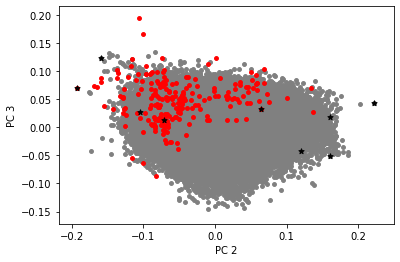

In [21]:
# Visualize selection on the kpca space:
plt.scatter(pfile[n_iza:,2],pfile[n_iza:,3],c='grey',s=15)
plt.scatter(pfile[0:n_iza,2],pfile[0:n_iza,3],c='red',s=15)
plt.scatter(pfile[absidx,2],pfile[absidx,3],s=30,marker='*',c='black')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.show()

In [13]:
print(ch_dist[absidx])
iza_ids = [s.info['Filename'] for s in db[0:n_iza]]
for i, d in zip(iza_ids, ch_dist[0:n_iza]):
    print(i[4:7], d)

[-0. -0. -0. -0. -0. -0. -0. -0. -0.]
ABW -0.0
ACO -0.0
AEI 1.3773190297644302
AEL 8.198786426769443
AEN 6.863192566352779
AET 12.426531236636153
AFG 2.356284878532126
AFI 8.989401661371364
AFN 7.522550718727672
AFO 7.849165117251068
AFR 6.834046796685427
AFS 6.859063092131093
AFT 1.6166588368767802
AFV 3.049767895297619
AFX 1.7879587083387085
AFY 14.638412494390384
AHT 17.30391444109842
ANA 6.258338199018544
APC 2.109818084753045
APD 8.357580371577006
AST 6.81250077646728
ASV 15.242794766702957
ATN 5.157862855076619
ATO 9.467079525057624
ATS 6.36308273822986
ATT 1.148549761400824
ATV 7.627636830732237
AVE 4.331583305043404
AVL 3.385486153744597
AWO 4.975090726380989
AWW 4.085076864976361
BCT 3.0773742107754365
BEC 8.494986972268691
BIK 6.8527182254197205
BOF 5.836875311191352
BOG 7.29759833400625
BOZ 11.698632317846233
BPH 7.293902089410453
BRE 4.271949074566798
BSV 27.685493789395725
CAN 2.772498307361159
CAS 8.001129392863048
CDO 8.186516450873913
CFI 9.460955925528669
CGF 7.5376572

In [14]:
print(np.mean(ch_dist[0:n_iza]), np.std(ch_dist[0:n_iza]), np.amax(ch_dist[0:n_iza]))
print(np.mean(ch_dist[n_iza:]), np.std(ch_dist[n_iza:]), np.amax(ch_dist[n_iza:]))

7.246020486298449 7.796584632622564 87.56925658230847
17.470689783388245 5.92773158527538 29.107453539867514


In [15]:
print(len([c for c in ch_dist if c <= 0]))
print(len([c for c in ch_dist[0:n_iza] if c <= 0]))
print(len([c for c in ch_dist[n_iza:] if c <= 0]))

36
9
27


In [16]:
vp = np.stack(vprobprune, axis=1)
print(vp.shape)
vp_nonzero = np.zeros(vp.shape[0])
for i in range(0, vp.shape[0]):
    nonzero_idxs = np.nonzero(vp[i, :])[0]
    if nonzero_idxs.size > 0:
        vp_nonzero[i] = vp[i, nonzero_idxs[-1]]
        
print(vp_nonzero[vp_nonzero > 0].size)

(331398, 41)
372


In [17]:
# Structure KPCA
np.savetxt('2D-IZA+330k/kpca2.dat', pfile[:, 1:3])

# Vertex probability for each structure at final nonzero probability
np.savetxt('2D-IZA+330k/vertex_probs.dat', vp_nonzero)

# T/F vertex of convex hull
np.savetxt('2D-IZA+330k/hullpoints.dat', vp_nonzero > 0.99, fmt='%s')

# Distance to the (reference) hull
np.savetxt('2D-IZA+330k/hull_distances.dat', ch_dist)

# IZA/DEEM label
np.savetxt('2D-IZA+330k/data_labels.dat', np.array(['IZA']*n_iza + ['DEEM']*n_deem), fmt='%4s')

# Within IZA envelope
np.savetxt('2D-IZA+330k/IZA_envelope.dat', ch_dist <= np.amax(ch_dist[0:n_iza]), fmt='%s')

In [18]:
# Indices within envelope (plotting all is too slow)
np.savetxt('2D-IZA+330k/envelope.idxs', ch_dist <= np.amax(ch_dist[0:n_iza]), fmt='%d')

In [19]:
np.count_nonzero(ch_dist <= np.amax(ch_dist[0:n_iza]))

331398